In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as sp
from PIL import Image
import math
import scipy.stats
Q_MATRIX = np.array([[8,8,6,6,4,4,2,2],
                       [8,8,6,6,4,4,2,2],
                       [6,6,6,6,4,4,2,2],
                       [6,6,6,6,4,4,2,2],
                       [4,4,4,4,4,4,2,2],
                       [4,4,4,4,4,4,2,2],
                       [2,2,2,2,2,2,2,2],
                       [2,2,2,2,2,2,2,2]],np.int32)

In [56]:
def snr(f,g):
    f = np.asanyarray(f, dtype="float")
    g = np.asanyarray(g, dtype="float")
    var = np.sum(np.square(f))
    rss = np.sum(np.square(f-g))
    return np.where(var == 0, float("inf"), 10*np.log10(var/rss))

In [4]:
def psnr(a,oa):
    a = np.asanyarray(a, dtype="float")
    mse = np.square(oa-a).mean()
    return np.where(mse == 0, 0, 10*np.log10(255*255/mse))

In [5]:
def mse(og,new):
    return np.square(og-new).mean()

In [6]:
def dct_wave(N, w):
    wave = np.zeros(N, dtype='float')
    
    if (w==0):
        norm_factor = np.sqrt(1/N)
    else:
        norm_factor = np.sqrt(2/N)
    for i in range(N):   
        wave[i] = norm_factor * np.cos( w * (np.pi * (2*i + 1))/(2*N) )
        
    return wave

In [7]:
def dct_wave_2d(N, u, v):
    
    wave_x = dct_wave(N, u)
    wave_y = dct_wave(N, v)
    
    return np.outer(wave_x, wave_y)

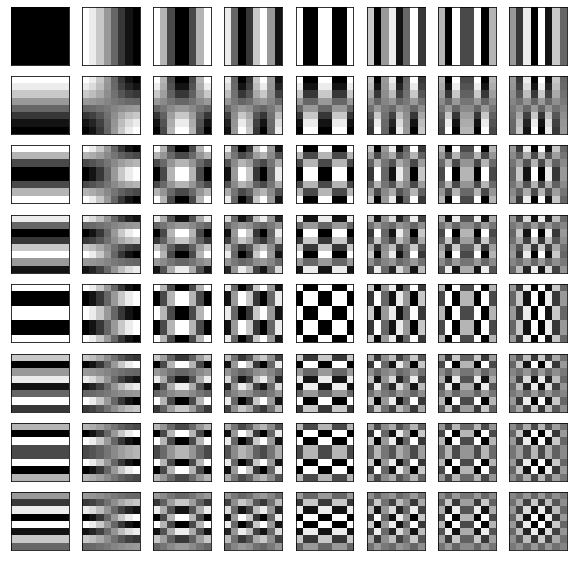

In [8]:
n = 8

fig = plt.figure(figsize=(10,10))
i = 0
for u in range(n):
    for v in range(n):
        
        plt.subplot(n,n,i+1)
        plt.imshow(dct_wave_2d(n, u, v), norm=None, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        i += 1

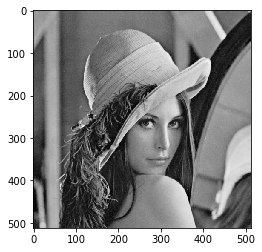

In [9]:
data_dir = r"C:\Users\callu\Pictures\Test\\"
#data_dir = r"./coursework-data/"
img = Image.open(data_dir+"lena.png").convert("L")
img = np.asarray(img)
plt.imshow(img, cmap="gray")
plt.show()
print(img.shape)

In [10]:
def DCT_inv(coeffs, dct_basis, N):
    recon = np.zeros((N,N))
    for k in range(N):
        for l in range(N):
            recon+=coeffs[k,l]*dct_basis[k,l]
    return recon

(512, 512)


In [11]:
def makeBasis(inp):
    inp=inp
    
    dct_basis = np.zeros((inp, inp, inp, inp)) 

    for k in range(inp):
        for l in range(inp):
            dct_basis[k, l] = dct_wave_2d(inp,k,l)
    
    return dct_basis

In [12]:
def dctBlock(im, dct_basis, N):
    coeffs = np.zeros((N,N))
    for k in range(N):
        for l in range(N):
            coefficient = np.dot(im.flatten(), dct_basis[k,l].flatten()) # dot product x.b
            coeffs[k,l] = coefficient
    return coeffs

In [13]:
def bdctTransform(image, bs, t=0, q=False):
    base = makeBasis(bs)
    dctim = np.zeros((image.shape))
    for i in range(0,image.shape[0],bs):
        for j in range(0,image.shape[1],bs):
            im = image[i:i+bs,j:j+bs]
            dctres = dctBlock(im,base,bs)
            if t<=0:
                None
            else:
                dctres = blockThresh(dctres, t)
            if q == True:
                dctres = qBlock(dctres)
            dctim[i:i+bs,j:j+bs] = dctres
    return dctim

In [14]:
def bidctTransform(dctim, bs):
    base = makeBasis(bs)
    recim = np.zeros((dctim.shape))
    for i in range(0,dctim.shape[0],bs):
        for j in range(0,dctim.shape[1],bs):
            im = dctim[i:i+bs,j:j+bs]
            recres = DCT_inv(im,base,bs)
            recim[i:i+bs,j:j+bs] = recres
    return recim

In [15]:
def blockThresh(block, thresh):
    bign = 0
    bigs = 0
    for r in block:
        for c in r:
            if c>bigs:
                if c>bign:
                    bigs=bign
                    bign=c
                bigs=c
    for x in range(block.shape[0]):
        for y in range(block.shape[0]):
            if abs(block[x,y])<thresh*bigs:
                block[x,y] = 0
    return block

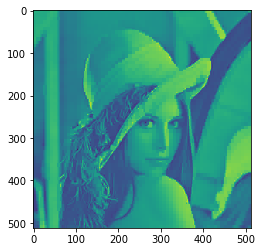

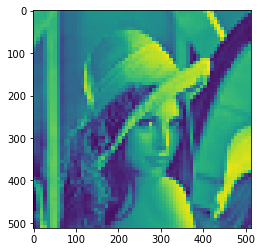

In [16]:
threshd = []
for i in range(0,10):
    thresh = i/10
    threshd.append(bidctTransform(bdctTransform(img,8,thresh),8))
    
plt.imshow(threshd[1])
plt.show()
plt.imshow(threshd[8])
plt.show()

In [57]:
#regular signal-to-noise
print(snr(img,img))
print(snr(img,threshd[0]))
print(snr(img,threshd[2]))
print(snr(img,threshd[4]))
print(snr(img,threshd[6]))
print(snr(img,threshd[8]))

123.54576873779297 4601581600.0 0.0
inf
123.54576873779298 4601581600.0 2.14841754116605e-20
293.3078843819107
123.54576873779298 4601581600.0 43506699.16147514
20.243509930219968
123.54576873779298 4601581600.0 64933920.71488775
18.504355013923227
123.54576873779298 4601581600.0 72048128.30145784
18.05284424789382
123.54576873779298 4601581600.0 73290884.4375
17.978571652174836


C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [18]:
#peak-signal-to-noise
#seems more common in image analysis
#function hardcoded with assumption that each pixel is being represented with 8-bits
print(psnr(img,img))
print(psnr(threshd[0],img))
print(psnr(threshd[1],img))
print(psnr(threshd[2],img))
print(psnr(threshd[4],img))
print(psnr(threshd[6],img))
print(psnr(threshd[8],img))

0.0
298.9950159322125
28.653230522152473
25.93064148052172
24.191486564224988
23.73997579819558
23.665703202476593


C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [19]:
MSE = mse(img, threshd[1])
print(MSE)

88.66603922456085


In [20]:
def qBlock(block, target=Q_MATRIX):
    quant = np.zeros(target.shape)
    #print(target)
    for x in range(block.shape[0]):
        for y in range(block.shape[1]):
            quant[x,y] = round(block[x,y]/target[x,y])*target[x,y]
    return quant

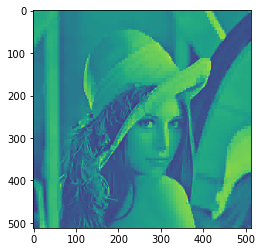

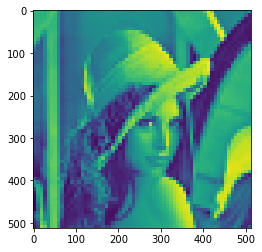

In [21]:
quantd = []
for i in range(0,10):
    thresh = i/10
    quantd.append(bidctTransform(bdctTransform(img,8,thresh,True),8))
    
plt.imshow(quantd[1])
plt.show()
plt.imshow(quantd[8])
plt.show()

In [58]:
print(snr(img,img))
print(snr(img,quantd[0]))
print(snr(img,quantd[2]))
print(snr(img,quantd[4]))
print(snr(img,quantd[6]))
print(snr(img,quantd[8]))

123.54576873779297 4601581600.0 0.0
inf
123.54614257812501 4601581600.0 377546.21116438025
40.85937011491958
123.546142578125 4601581600.0 43531711.35931343
20.241013869059046
123.54614257812501 4601581600.0 64956264.92366225
18.50286083380157
123.54614257812501 4601581600.0 72070127.16697726
18.051518394212568
123.54614257812501 4601581600.0 73312862.0
17.977269538903805


C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [23]:
print(psnr(img,img))
print(psnr(quantd[0],img))
print(psnr(quantd[1],img))
print(psnr(quantd[2],img))
print(psnr(quantd[4],img))
print(psnr(quantd[6],img))
print(psnr(quantd[8],img))

0.0
46.54650166522133
28.647174930261198
25.928145419360806
24.18999238410333
23.73864994451433
23.664401089205565


C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [24]:
MSE = mse(img, quantd[1])
print(MSE)

88.78975708788661


43.52046211247209
88.66603922456085
181.90360247098613
366.52472030024796


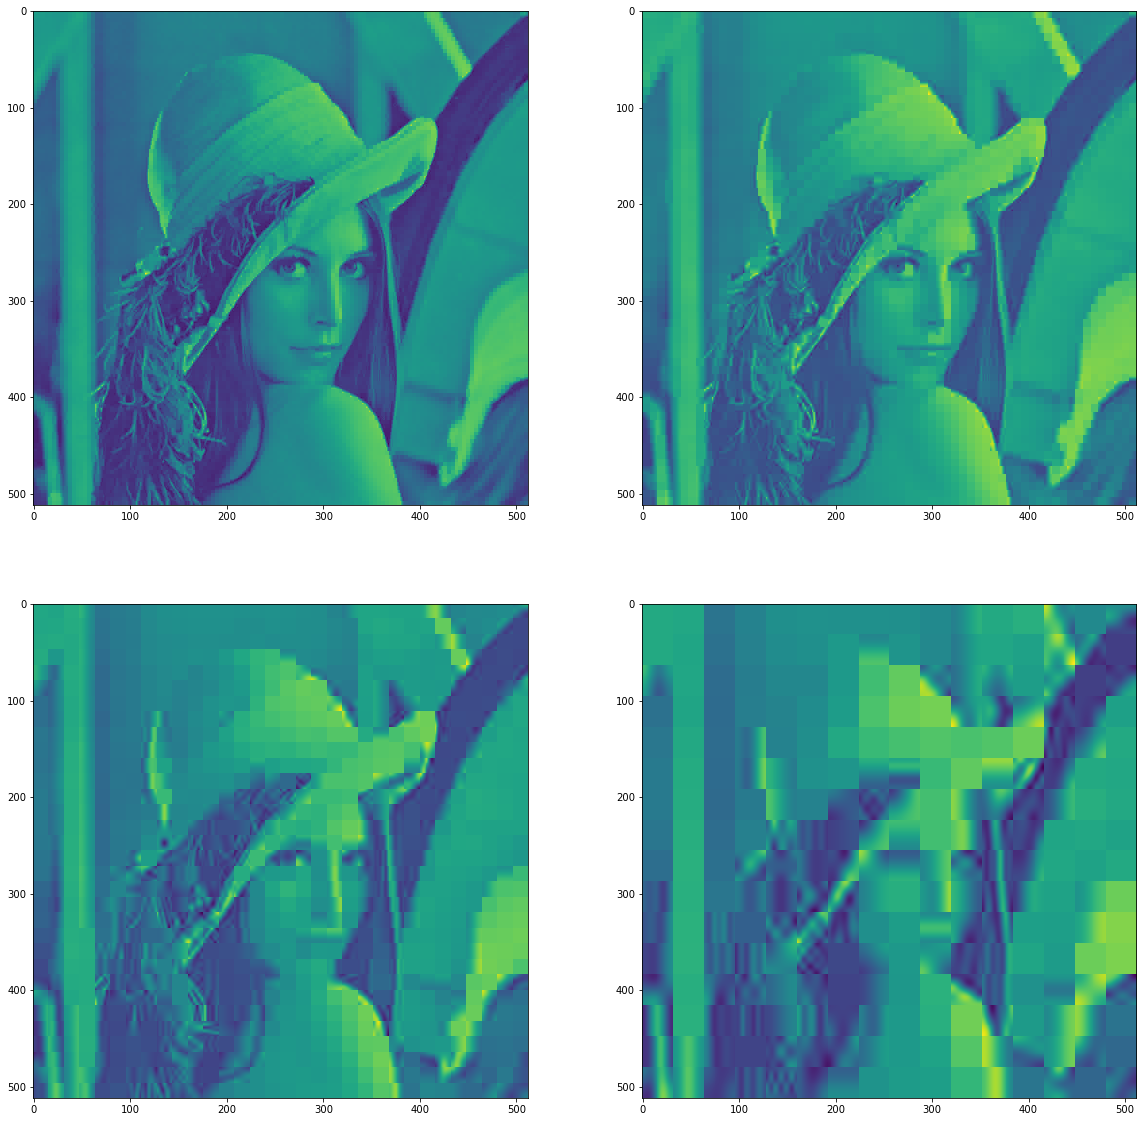

In [25]:
thresh = 0.1
four = bidctTransform(bdctTransform(img,4,thresh),4)
print(mse(img,four))
eight = bidctTransform(bdctTransform(img,8,thresh),8)
print(mse(img,eight))
sixteen = bidctTransform(bdctTransform(img,16,thresh),16)
print(mse(img,sixteen))
thirtytwo = bidctTransform(bdctTransform(img,32,thresh),32)
print(mse(img,thirtytwo))
fig = plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(four)
plt.subplot(2,2,2)
plt.imshow(eight)
plt.subplot(2,2,3)
plt.imshow(sixteen)
plt.subplot(2,2,4)
plt.imshow(thirtytwo)
plt.show()

In [26]:
def gaussian_kernel(sigma, norm=True):
    
    size = int(np.ceil(6 * sigma))  # kernel width is 6 x sigma
    
    if (size%2==0): # is the size even?
        size = size + 1 # make it odd 
        
    kernel = np.zeros((size,size), dtype='float') # kernel array
    
    h = size//2 # half size
    for y in range(0,size):
        for x in range(0,size):
            x2 = (x-h)*(x-h)
            y2 = (y-h)*(y-h)
            kernel[y, x] = np.exp(-(x2+y2)/(2*sigma*sigma))
    
    if norm:
        kernel /= np.sum(kernel) # normalise the kernel
    
    return kernel

In [27]:
def conv2d(im, kernel):

    h = kernel.shape[0]//2 # half the kernel size
    impad = np.pad(im,h,"edge")
    output = np.zeros(im.shape, dtype='float')
    for i in range(h,impad.shape[0]-h):
        for j in range(h,impad.shape[1]-h):

            output[i-h, j-h] = np.dot(impad[i-h:i+h+1,j-h:j+h+1].flatten(), kernel.flatten())
    return output

In [167]:
def reduce(im, kernel):
    
    # blur the input 
    im_blurred = conv2d(im.astype('float'), kernel)
    return im_blurred[::2,::2] # return subsampled version

def expand(im, kernel):

    # upsample by a factor of two by pixel duplication
    upsampled = np.zeros((2*im.shape[0], 2*im.shape[1]), dtype=im.dtype)
    for i in range(upsampled.shape[0]):
        for j in range(upsampled.shape[1]):
            upsampled[i, j] = im[i//2,j//2]

    # blur the upsampled image
    blurred = conv2d(upsampled.astype('float'), kernel)

    return blurred

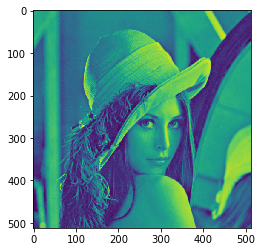

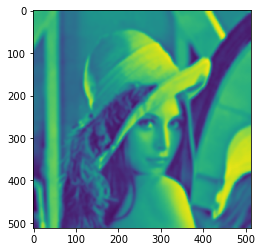

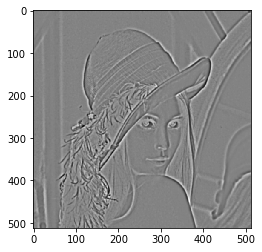

In [171]:
plt.imshow(img)
plt.show()

big = gaussian_kernel(3)
smol = gaussian_kernel(1)

blurred = conv2d(img,big)
padded_kernel = np.pad(smol, (big.shape[0]-smol.shape[0])//2, 'constant')
dog = big - padded_kernel

plt.imshow(blurred)
plt.show()

dogged = conv2d(img,dog)
plt.imshow(dogged, cmap="gray")
plt.show()

In [220]:
def build_pyramids(img, g):
    gauss_pyramid = [] # list to store the generated levels

    gauss_pyramid.append(img.astype('float')) # level 0 is the image

    n = int(np.log2(img.shape[0]))+1 # assume that the image size is a power of 2
    for i in range(1,n):

        print(i)
        
        level = reduce(gauss_pyramid[i-1], g)

        gauss_pyramid.append(level)

    lap_pyramid=[]
    for j in range(0,n-1):
        diff = gauss_pyramid[j]-expand(gauss_pyramid[j+1],g)
        #diff *= (255.0/diff.max())
        lap_pyramid.append(diff)

    return gauss_pyramid,lap_pyramid

def show_pyramid(pyramid):

        fig = plt.figure(figsize=(18,7))

        for i in range(len(pyramid)):

            plt.subplot(2,5,i+1)
            plt.imshow(pyramid[i], cmap='gray')
            plt.title('level '+str(i))
            plt.xticks([])
            plt.yticks([])

        plt.show()

1
2
3
4
5
6
7
8
9


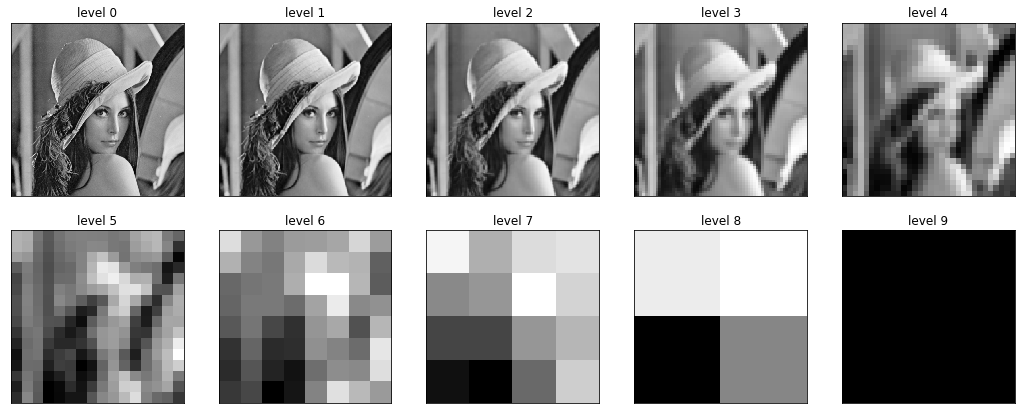

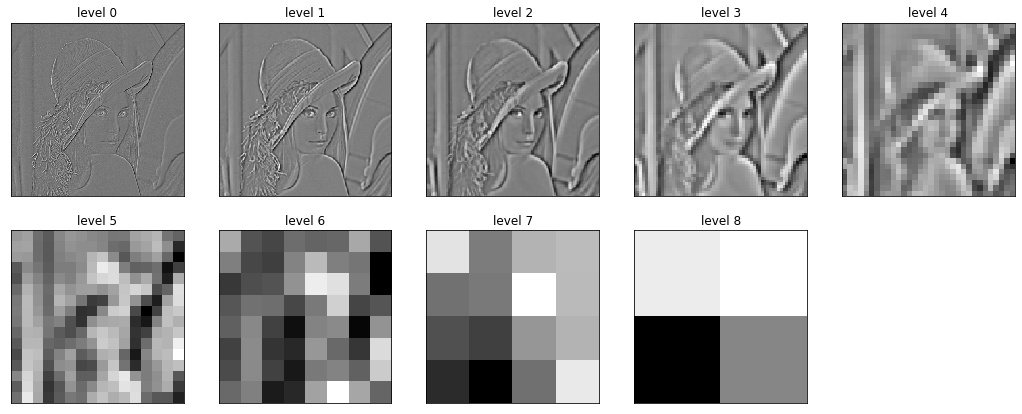

In [221]:
gauss,lapl = build_pyramids(img, smol)

show_pyramid(gauss)

show_pyramid(lapl)

255.00000000000003
255.0
255.0
255.00000000000003
255.0
255.0
255.0
254.99999999999997
255.00000000000003


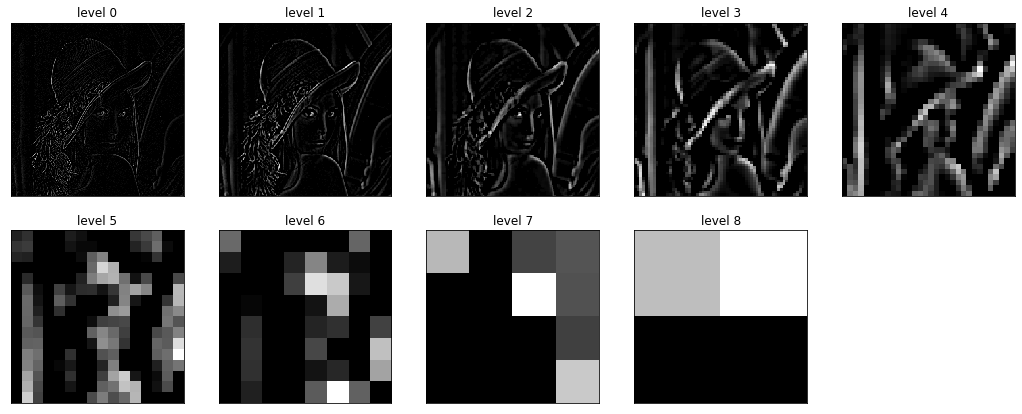

In [99]:
thresh_lap = []
for xj in range(len(lapl)):
    temp_store = []
    pmax = 0
    for pix in lapl[xj].ravel():
        if pix>pmax:
            pmax=pix
    print(pmax)
    for pix in lapl[xj].ravel():
        if pix>(0.1*pmax):
            temp_store.append(pix)
        else:
            temp_store.append(0)
    new_store = np.asarray(temp_store)
    thresh_lap.append(new_store.reshape((int(512//math.pow(2,(xj)))), int(512//math.pow(2,(xj)))))

show_pyramid(thresh_lap)

In [235]:
def threshPyramid(pyramid):
    result = []
    for xj in range(len(pyramid)):
        temp_store = []
        pmax = 0
        for pix in pyramid[xj].ravel():
            if abs(pix)>pmax:
                pmax=abs(pix)
        for pix in pyramid[xj].ravel():
            if abs(pix)>(0.1*pmax):
                temp_store.append(pix)
            else:
                temp_store.append(0)
        new_store = np.asarray(temp_store)
        result.append(new_store.reshape((int(512//math.pow(2,(xj)))), int(512//math.pow(2,(xj)))))
    return result

In [232]:
thresh_lap = threshPyramid(lapl)
quant_lap = threshPyramid(lapl)

In [198]:
def quantisePyramid(pyramid):
    depth = len(pyramid)
    for i in range(0,depth):
        for x in range(pyramid[i].shape[0]):
            for y in range(pyramid[i].shape[1]):
                pyramid[i][x,y] = np.floor(pyramid[i][x,y]/(pyramid[i].max()/np.power(2,(i+1))))*(pyramid[i].max()/np.power(2,(i+1)))
    return pyramid

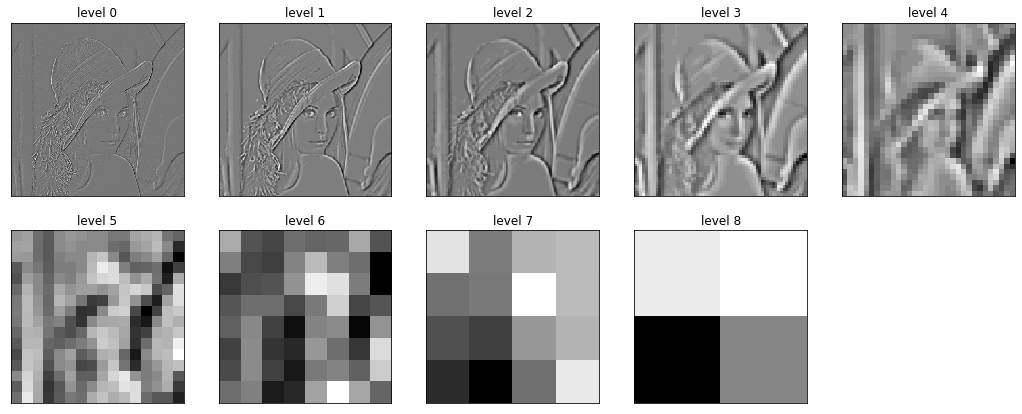

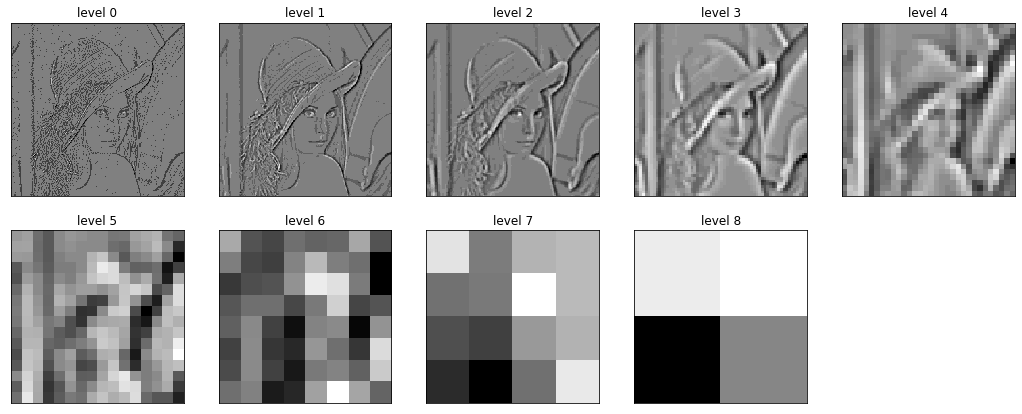

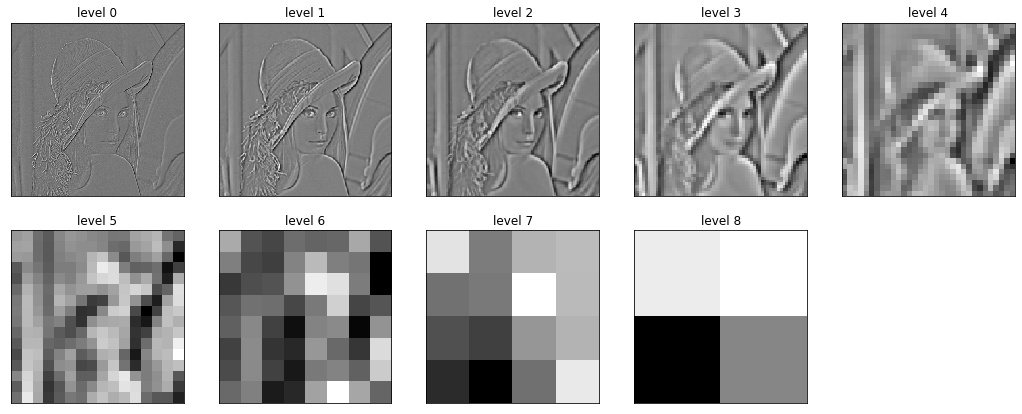

In [233]:
quantisePyramid(quant_lap)
show_pyramid(thresh_lap)
show_pyramid(quant_lap)
show_pyramid(lapl)

In [226]:
print(lapl[0])

[[ 1.95293491e-02  8.98745131e-02  2.70303116e-01 ...  5.92621376e+00
  -2.14378175e+00 -2.38345259e+01]
 [ 1.72247337e-02  8.98178398e-02  2.73823121e-01 ...  6.02692861e+00
  -2.02762536e+00 -2.37100670e+01]
 [ 4.12497579e-03  9.19269121e-02  3.00076338e-01 ...  6.82602645e+00
  -1.11619623e+00 -2.27389248e+01]
 ...
 [-4.10865659e+00 -4.78595542e+00  1.00954110e+00 ...  7.05320357e+00
   1.95928974e+00 -4.61439428e-01]
 [-1.76119786e+00 -2.81145837e+00  6.37527533e+00 ...  3.31758006e+00
   4.17995717e+00  5.69130440e+00]
 [-1.00816265e+00 -2.28698773e+00  6.52805442e+00 ...  1.91632088e+00
   2.71703921e+00  4.16752936e+00]]


0
1
2
3
4
5
6
7
8
(512, 512)


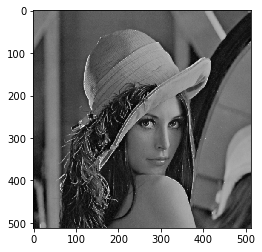

(256, 256)


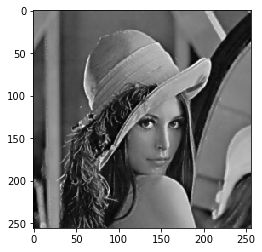

(128, 128)


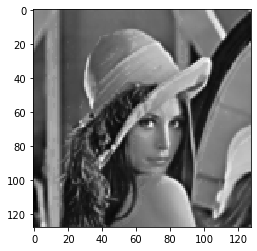

(64, 64)


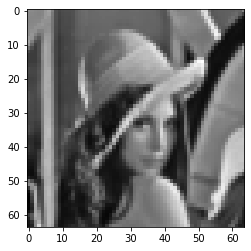

(32, 32)


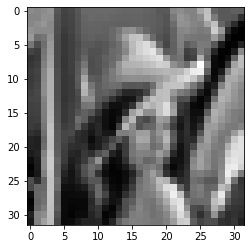

(16, 16)


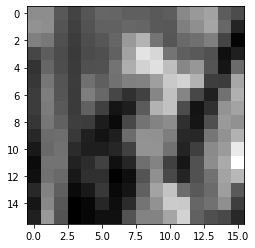

(8, 8)


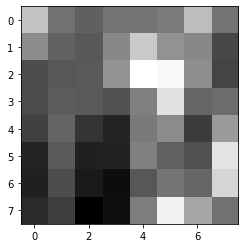

(4, 4)


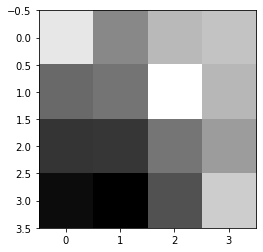

(2, 2)


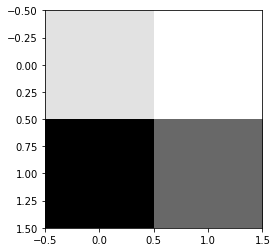

In [177]:
new_comb=[]
for level in range(len(quant_lap)):
    print(level)
    new_comb.append(gauss[level] + quant_lap[level])

for nc in new_comb:
    print(nc.shape)
    plt.imshow(nc,cmap='gray')
    plt.show()

In [123]:
new_comb=[]
for level in range(len(quant_lap)):
    print(level)
    new_comb.append(gauss[level] + quant_lap[level])

for nc in new_comb:
    print(nc.shape)
    plt.imshow(nc,cmap='gray')
    plt.show()

230.78839002295138


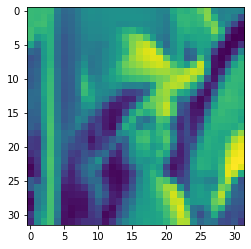

A (32, 32)
B (32, 32)


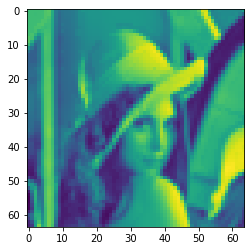

A (64, 64)
B (64, 64)


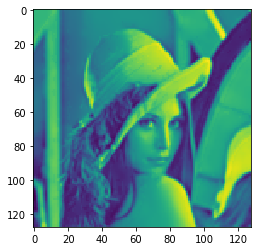

A (128, 128)
B (128, 128)


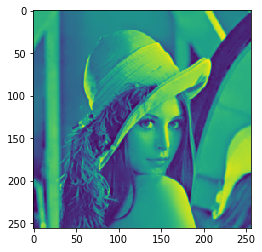

A (256, 256)
B (256, 256)


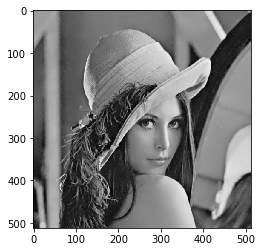

A (512, 512)
B (512, 512)


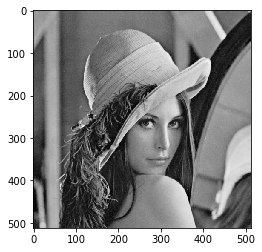

In [237]:
new_im = thresh_lap[4] + expand(gauss[5],smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[4].shape)
new_im = thresh_lap[3] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[3].shape)
new_im = thresh_lap[2] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[2].shape)
new_im = thresh_lap[1] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[1].shape)
new_im = thresh_lap[0] + expand(new_im,smol)
new_im *= (255.0/new_im.max())
plt.imshow(new_im, cmap="gray")
plt.show()
print("A",new_im.shape)
print("B",gauss[0].shape)
plt.imshow(img, cmap="gray")
plt.show()

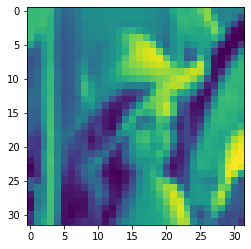

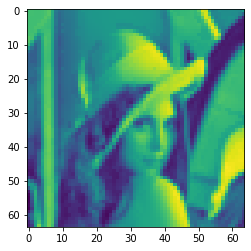

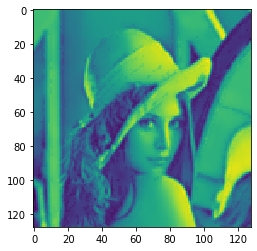

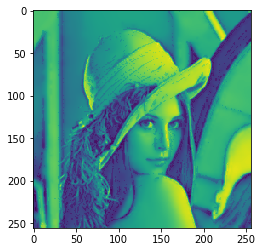

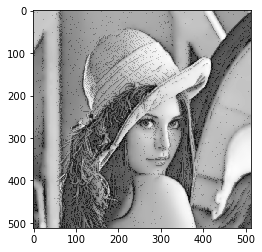

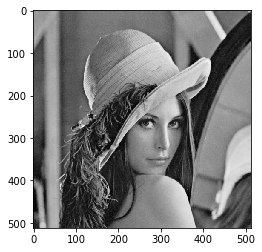

In [236]:
new_im = quant_lap[4] + expand(gauss[5],smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[3] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[2] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[1] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[0] + expand(new_im,smol)
plt.imshow(new_im, cmap="gray")
plt.show()
plt.imshow(img, cmap="gray")
plt.show()

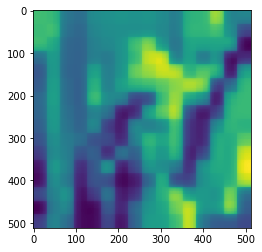

In [170]:
test = expand(expand(expand(expand(expand(reduce(reduce(reduce(reduce(reduce(img, smol),smol),smol),smol),smol),smol),smol),smol),smol),smol)
plt.imshow(test)
plt.show()
#print(test.shape)